## Task 1: Machine Learning with Matrix Data for Recommender Systems 

#### **Q1**

In [211]:
import numpy as np


def euc_dis(x1, x2):
  
  return np.sqrt(np.sum((x1 - x2) ** 2))

def cos_dis(x1, x2):
  
  numerator = np.dot(x1, x2)
  denominator = np.linalg.norm(x1) * np.linalg.norm(x2)
  return numerator / (denominator + np.finfo(float).eps) if denominator > 0 else 0

def jac_dis(x1, x2):
  if len(x1) != len(x2):
    raise ValueError("Not same dimensions.")
  numerator = np.minimum(x1, x2).sum()
  denominator = np.maximum(x1, x2).sum()
  return 1-(numerator/denominator)
# data = df.values

def minmax(data):
  
  scaled_data = data.copy()
  min_vals = np.min(data, axis=0)
  max_vals = np.max(data, axis=0)
  for i in range(data.shape[1]):
    scaled_data[:, i] = (data[:, i] - min_vals[i]) / (max_vals[i] - min_vals[i])
  return scaled_data



In [212]:
def calculate_sse(data, centers, assignments):
  
  sse = 0
  for i in range(len(data)):
    if len(data[i]) != len(centers[assignments[i]]):
      raise ValueError("Data points and centers must have the same number of features.")
    distance = np.sum((data[i] - centers[assignments[i]])**2)
    sse += distance
  return sse

def kmeans(data, k, dist_mes=euc_dis):
  
  centers = None
  if dist_mes == euc_dis:
    centers = data[np.random.choice(len(data), k, replace=False)]
  else:
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    centers = np.random.uniform(low=min_vals, high=max_vals, size=(k, data.shape[1]))

  counter = 0
  while True:
    distances = None
    if dist_mes == cos_dis:
      distances = np.array([
          [dist_mes(x, center) for center in centers] for x in data
      ])
      assignments = np.argmax(distances, axis=1) 
    else:
      distances = np.array([
          [dist_mes(x, center) for center in centers] for x in data
      ])
      assignments = np.argmin(distances, axis=1)
    new_centers = np.array([
        np.mean(data[assignments == i], axis=0) for i in range(k)
    ])
    if(np.isnan(new_centers).any()):
        print("break")
        break
    if np.all(np.linalg.norm(centers - new_centers, axis=1) < 1e-6):
      break

    centers = new_centers
  assigments = np.argmin(distances, axis=1)
  sse = calculate_sse(data, centers, assigments)
  return centers, sse, assignments

In [213]:
import pandas as pd

df = pd.read_csv('/Users/rohitbathi/Desktop/Masters/sem2/DM/assignments/HW3/RecSys/kmeans_data/data.csv', header=None)
data = df.values
k = 10
SSEs = {}
# Using Euclidean distance
centers, sse_euclidean,_ = kmeans(data, k)
SSEs["Euclidean distance"] = sse_euclidean

# Using cosine similarity
centers, sse_cosine, _ = kmeans(data, k, dist_mes=cosine_similarity)
SSEs["Cosine similarity"] = sse_cosine

# Using Jaccard similarity
centers, sse_jaccard, _ = kmeans(data, k, dist_mes=jaccard_distance)
SSEs["Jaccard Similarity"] = sse_jaccard

In [214]:
SSEs

{'Euclidean distance': 25523225629.072815,
 'Cosine similarity': 57625768452.60377,
 'Jaccard Similarity': 25416164805.817154}

#### **Q2**

In [218]:
def calculate_accuracy(data_labels, cluster_labels, assignments):
  correct_assignments = 0
  for i in range(len(data_labels)):
    assigned_cluster_label = cluster_labels[assignments[i]]

    if assigned_cluster_label == data_labels[i]:
      correct_assignments += 1

  accuracy = correct_assignments / len(data_labels)
  return accuracy

def assign_labels_to_clusters(data, labels, assignments):
  k = np.unique(assignments).shape[0] 
  cluster_labels = np.zeros(k, dtype=int) 

  for i in range(k):
    cluster_data_points = data[assignments == i]
    cluster_labels[i] = np.argmax(np.bincount(labels[assignments == i]))  

  return cluster_labels

In [219]:
labels = pd.read_csv("/Users/rohitbathi/Desktop/Masters/sem2/DM/assignments/HW3/RecSys/kmeans_data/label.csv", header=None)[0].to_numpy()
metrics = [euc_dis, cos_dis, jac_dis]
accuracies = {}
for metric in metrics:
  centers, _, assignments = kmeans(data, k, metric)

  cluster_labels = assign_labels_to_clusters(data, labels, assignments)

  accuracy = calculate_accuracy(labels, cluster_labels, assignments)
  accuracies[metric.__name__] = accuracy

for metric, accuracy in accuracies.items():
  print(f"{metric}: {accuracy:.4f}")


euclidean_distance: 0.5989
cosine_similarity: 0.6242
jaccard_distance: 0.6059


#### **Q3**

In [220]:
import time
def kmeans_no_cent_change(data, k, d_met=euc_dis):

  start_time = time.time()
  cents = None
  if d_met == euc_dis:
    cents = data[np.random.choice(len(data), k, replace=False)]
  else:
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    cents = np.random.uniform(low=min_vals, high=max_vals, size=(k, data.shape[1]))
  iters = 0
  counter = 0

  while True:
    iters +=1
    dists = None
    if d_met == cos_dis:
      dists = np.array([
          [d_met(x, cent) for cent in cents] for x in data
      ])
      assign = np.argmax(dists, axis=1) 
    else:
      dists = np.array([
          [d_met(x, cent) for cent in cents] for x in data
      ])
      assign = np.argmin(dists, axis=1)
    new_cents = np.array([
        np.mean(data[assign == i], axis=0) for i in range(k)
    ])
    if(np.isnan(new_cents).any()):
        break
    if np.all(np.linalg.norm(cents - new_cents, axis=1) < 1e-6):
      break

    cents = new_cents
  assign = np.argmin(dists, axis=1)
  sse = calculate_sse(data, cents, assign)
  end_time = time.time()  
  total_time = end_time - start_time
  return cents, sse, assign, iters, total_time

def kmeans_no_SSE(data, k, d_met=euc_dis):

  start_time = time.time()
  iters = 0
  cents = None
  if d_met == euc_dis:
    cents = data[np.random.choice(len(data), k, replace=False)]
  else:
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    cents = np.random.uniform(low=min_vals, high=max_vals, size=(k, data.shape[1]))
  assign=None
  counter = 0
  prev_sse = float('inf')
  while True:
    iters +=1
    dists = None
    if d_met == cos_dis:
      dists = np.array([
          [d_met(x, cent) for cent in cents] for x in data
      ])
      assign = np.argmax(dists, axis=1)  
    else:
      dists = np.array([
          [d_met(x, cent) for cent in cents] for x in data
      ])
      assign = np.argmin(dists, axis=1)
    new_cents = np.array([
        np.mean(data[assign == i], axis=0) for i in range(k)
    ])
    current_sse = calculate_sse(data, new_cents, assign)
    if(np.isnan(new_cents).any()):
        break

    if current_sse >= prev_sse:
      break
    prev_sse = current_sse
    cents = new_cents
  assign = np.argmin(dists, axis=1)
  sse = calculate_sse(data, cents, assign)
  end_time = time.time()
  total_time = end_time - start_time
  return cents, sse, assign, iters, total_time

def kmeans_max_pre(data, k, d_met=euc_dis, max_iter = 500):

  start_time = time.time()
  iters = 0
  cents = None
  if d_met == euc_dis:
    cents = data[np.random.choice(len(data), k, replace=False)]
  else:
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    cents = np.random.uniform(low=min_vals, high=max_vals, size=(k, data.shape[1]))
  counter = 0
  for i in range(max_iter):
    iters +=1
    dists = None
    if d_met == cos_dis:
      dists = np.array([
          [d_met(x, cent) for cent in cents] for x in data
      ])
      assign = np.argmax(dists, axis=1) 
    else:
      dists = np.array([
          [d_met(x, cent) for cent in cents] for x in data
      ])
      assign = np.argmin(dists, axis=1)
    new_cents = np.array([
        np.mean(data[assign == i], axis=0) for i in range(k)
    ])
    if(np.isnan(new_cents).any()):
        break
    if np.all(np.linalg.norm(cents - new_cents, axis=1) < 1e-6):
      break
    cents = new_cents
  assign = np.argmin(dists, axis=1)
  sse = calculate_sse(data, cents, assign)
  end_time = time.time()  
  total_time = end_time - start_time
  return cents, sse, assign, iters, total_time

In [222]:
data = df.values
results = {}
results["no_center_change"] = {}
results["sse_change"] = {}
results["max_preset"] = {}
# convergence tests
# No center change
for metric in metrics:
  centers, sse, _2, iterations, time_taken = kmeans_no_cent_change(data, k, metric)
  results["no_center_change"][metric.__name__] = {"iterations": iterations, "time_taken": time_taken, "sse": sse}

# SSE change 
for metric in metrics:
  centers, sse, _2, iterations, time_taken = kmeans_no_SSE(data, k, metric)
  results["sse_change"][metric.__name__] = {"iterations": iterations, "time_taken": time_taken, "sse": sse}

# Max preset 
for metric in metrics:
  centers, sse, _2, iterations, time_taken = kmeans_max_pre(data, k, metric, 100)
  results["max_preset"][metric.__name__] = {"iterations": iterations, "time_taken": time_taken, "sse": sse}

# Print res
print("Results:\n", results)

Results:
 {'no_center_change': {'euclidean_distance': {'iterations': 57, 'time_taken': 38.75575661659241, 'sse': 25369162893.13935}, 'cosine_similarity': {'iterations': 48, 'time_taken': 46.843945026397705, 'sse': 56014535887.01433}, 'jaccard_distance': {'iterations': 50, 'time_taken': 38.5790319442749, 'sse': 25416535169.182774}}, 'sse_change': {'euclidean_distance': {'iterations': 54, 'time_taken': 39.512253284454346, 'sse': 25323744315.181164}, 'cosine_similarity': {'iterations': 16, 'time_taken': 16.236051082611084, 'sse': 55920139805.445984}, 'jaccard_distance': {'iterations': 47, 'time_taken': 40.07735872268677, 'sse': 25424016248.025265}}, 'max_preset': {'euclidean_distance': {'iterations': 33, 'time_taken': 22.618321180343628, 'sse': 25533983454.726112}, 'cosine_similarity': {'iterations': 83, 'time_taken': 81.98930788040161, 'sse': 56856173988.049095}, 'jaccard_distance': {'iterations': 45, 'time_taken': 43.4767849445343, 'sse': 25592416141.65567}}}


In [223]:
convert_result = {}


for item in results:
  # print(item)
  for metric in results[item]:
    # print(metric," - ",results[item][metric])
    if metric not in convert_result:
      convert_result[metric] = {}
      convert_result[metric][item] = results[item][metric]
    else:
      convert_result[metric][item] = results[item][metric]

for metric in convert_result:
  print("\n",metric,"\n")
  for item in convert_result[metric]:
    print(item," - ",convert_result[metric][item])


 euclidean_distance 

no_center_change  -  {'iterations': 57, 'time_taken': 38.75575661659241, 'sse': 25369162893.13935}
sse_change  -  {'iterations': 54, 'time_taken': 39.512253284454346, 'sse': 25323744315.181164}
max_preset  -  {'iterations': 33, 'time_taken': 22.618321180343628, 'sse': 25533983454.726112}

 cosine_similarity 

no_center_change  -  {'iterations': 48, 'time_taken': 46.843945026397705, 'sse': 56014535887.01433}
sse_change  -  {'iterations': 16, 'time_taken': 16.236051082611084, 'sse': 55920139805.445984}
max_preset  -  {'iterations': 83, 'time_taken': 81.98930788040161, 'sse': 56856173988.049095}

 jaccard_distance 

no_center_change  -  {'iterations': 50, 'time_taken': 38.5790319442749, 'sse': 25416535169.182774}
sse_change  -  {'iterations': 47, 'time_taken': 40.07735872268677, 'sse': 25424016248.025265}
max_preset  -  {'iterations': 45, 'time_taken': 43.4767849445343, 'sse': 25592416141.65567}


## Task 2 : Machine Learning with Matrix Data for Recommender Systems

##### Probabilistic Matrix Factorization (PMF)

In [151]:
import os
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate

fpath = os.path.expanduser('/Users/rohitbathi/Desktop/Masters/sem2/DM/assignments/HW3/RecSys/ratings_small.csv')
reader = Reader(line_format="user item rating timestamp", sep=',')

data = Dataset.load_from_file(fpath, reader=reader)

pmf = SVD(biased=False)

cross_validate(pmf, data, measures=['rmse', 'mae'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0135  1.0067  1.0101  0.9977  1.0172  1.0090  0.0067  
MAE (testset)     0.7784  0.7770  0.7801  0.7719  0.7891  0.7793  0.0056  
Fit time          0.68    0.61    0.60    0.58    0.65    0.62    0.04    
Test time         0.05    0.10    0.05    0.09    0.05    0.07    0.02    


{'test_rmse': array([1.01350946, 1.00673697, 1.01005069, 0.99766705, 1.01719711]),
 'test_mae': array([0.77842444, 0.77702433, 0.78006868, 0.771927  , 0.78907891]),
 'fit_time': (0.6843729019165039,
  0.6087722778320312,
  0.5989210605621338,
  0.5762591361999512,
  0.6485691070556641),
 'test_time': (0.05291581153869629,
  0.10375189781188965,
  0.04877209663391113,
  0.09460616111755371,
  0.05018806457519531)}

##### User based Collaborative Filtering

In [152]:
u_cf = KNNBasic(
    sim_options={
        'user_based':True
    }
)

cross_validate(u_cf, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9606  0.9570  0.9676  0.9718  0.9725  0.9659  0.0061  
MAE (testset)     0.7393  0.7373  0.7437  0.7473  0.7478  0.7431  0.0042  
Fit time          0.04    0.05    0.05    0.05    0.06    0.05    0.00    
Test time         0.60    0.70    0.60    0.62    0.67    0.64    0.04    


{'test_rmse': array([0.96063974, 0.95701116, 0.96761652, 0.97175014, 0.97248556]),
 'test_mae': array([0.73926043, 0.73728344, 0.74370046, 0.74727946, 0.74777053]),
 'fit_time': (0.04401087760925293,
  0.0509188175201416,
  0.05060911178588867,
  0.05196714401245117,
  0.0589599609375),
 'test_time': (0.6008362770080566,
  0.7041549682617188,
  0.6001248359680176,
  0.617344856262207,
  0.6694660186767578)}

##### Item based Collaborative Filtering

In [153]:
i_cf = KNNBasic(
    sim_options={
        'user_based':False
    }
)
cross_validate(pmf, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9961  1.0162  1.0127  1.0103  1.0014  1.0073  0.0074  
MAE (testset)     0.7681  0.7845  0.7781  0.7831  0.7756  0.7779  0.0059  
Fit time          0.63    0.67    0.63    0.60    0.61    0.63    0.02    
Test time         0.05    0.05    0.05    0.05    0.05    0.05    0.00    


{'test_rmse': array([0.9961221 , 1.01617968, 1.01265608, 1.01026629, 1.00140342]),
 'test_mae': array([0.76809194, 0.78450685, 0.77809952, 0.78312841, 0.77561312]),
 'fit_time': (0.6310210227966309,
  0.6707589626312256,
  0.6300129890441895,
  0.6002788543701172,
  0.6109602451324463),
 'test_time': (0.04925394058227539,
  0.05163693428039551,
  0.05093097686767578,
  0.05050182342529297,
  0.04975390434265137)}

##### Cosine similarity used in PMF, UCF, ICF

In [154]:
import os
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate

fpath = os.path.expanduser('/Users/rohitbathi/Desktop/Masters/sem2/DM/assignments/HW3/RecSys/ratings_small.csv')
reader = Reader(line_format="user item rating timestamp", sep=',')

data = Dataset.load_from_file(fpath, reader=reader)

cosine_ucf = KNNBasic(
    sim_options={
        'name': 'cosine',
        'user_based': True
    }
)
cosine_icf = KNNBasic(
    sim_options={
        'name': 'cosine',
        'user_based': False
    }
)

ucf_res = cross_validate(cosine_ucf, data, measures=['rmse','mae'], cv=5, verbose=False)
icf_res = cross_validate(cosine_icf, data, measures=['rmse','mae'], cv=5, verbose=False)

rmse_ucf_res = [np.mean(ucf_res['test_rmse'])]
mae_ucf_res = [np.mean(icf_res['test_mae'])]
rmse_icf_res = [np.mean(icf_res['test_rmse'])]
mae_icf_res = [np.mean(icf_res['test_mae'])]

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


##### Pearson similarity used in PMF, UCF, ICF

In [155]:
pearson_ucf = KNNBasic(
    sim_options={
        'name': 'pearson',
        'user_based': True
    }
)
pearson_icf = KNNBasic(
    sim_options={
        'name': 'pearson',
        'user_based': False
    }
)

ucf_res = cross_validate(pearson_ucf, data, measures=['rmse','mae'], cv=5, verbose=False)
icf_res = cross_validate(pearson_icf, data, measures=['rmse','mae'], cv=5, verbose=False)

rmse_ucf_res.append(np.mean(ucf_res['test_rmse']))
mae_ucf_res.append(np.mean(icf_res['test_mae']))
rmse_icf_res.append(np.mean(icf_res['test_rmse']))
mae_icf_res.append(np.mean(icf_res['test_mae']))

print(rmse_ucf_res)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
[0.9939581389908569, 0.9977716237215775]


##### MSD similarity used in PMF, UCF, ICF

In [156]:
msd_ucf = KNNBasic(
    sim_options={
        'name': 'msd',
        'user_based': True
    }
)
msd_icf = KNNBasic(
    sim_options={
        'name': 'msd',
        'user_based': False
    }
)

ucf_res = cross_validate(msd_ucf, data, measures=['rmse','mae'], cv=5, verbose=False)
icf_res = cross_validate(msd_icf, data, measures=['rmse','mae'], cv=5, verbose=False)

rmse_ucf_res.append(np.mean(ucf_res['test_rmse']))
mae_ucf_res.append(np.mean(icf_res['test_mae']))
rmse_icf_res.append(np.mean(icf_res['test_rmse']))
mae_icf_res.append(np.mean(icf_res['test_mae']))


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


##### Plotting error rates of different similarities in UCF and ICF

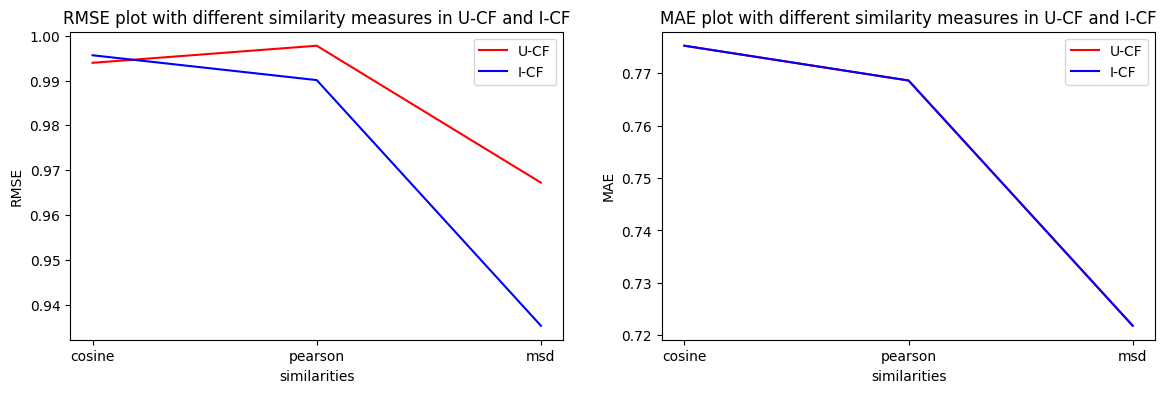

In [157]:
import matplotlib.pyplot as plt

names = ['cosine', 'pearson', 'msd']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14,4))

ax1.set_title('RMSE plot with different similarity measures in U-CF and I-CF')
ax1.plot(names, rmse_ucf_res, '-r', label='U-CF')
ax1.plot(names, rmse_icf_res, '-b', label='I-CF')
ax1.legend(loc='upper right')
ax1.set(xlabel='similarities', ylabel='RMSE')

ax2.set_title('MAE plot with different similarity measures in U-CF and I-CF')
ax2.plot(names, mae_ucf_res, 'r', label='U-CF')
ax2.plot(names, mae_icf_res, 'b', label='I-CF')
ax2.legend(loc='upper right')
ax2.set(xlabel='similarities', ylabel='MAE')

plt.show()

##### Plotting k-neightbour effect on U-CF and I-CF

In [158]:
ucf = None
icf=  None
rmse_ucf =  []
rmse_icf =  []
mae_ucf =  []
mae_icf =  []
for i in range(1, 201, 10):
    ucf = KNNBasic(
        k=i,
        sim_options={'user_based': True}
    )
    icf = KNNBasic(
        k=i,
        sim_options={'user_based': False}
    )
    ucf_res = cross_validate(ucf, data, measures=['rmse', 'mae'], cv=5, verbose=False)
    icf_res = cross_validate(icf, data, measures=['rmse', 'mae'], cv=5, verbose=False)

    rmse_ucf.append(np.mean(ucf_res['test_rmse']))
    mae_ucf.append(np.mean(ucf_res['test_mae']))
    rmse_icf.append(np.mean(icf_res['test_rmse']))
    mae_icf.append(np.mean(icf_res['test_mae']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

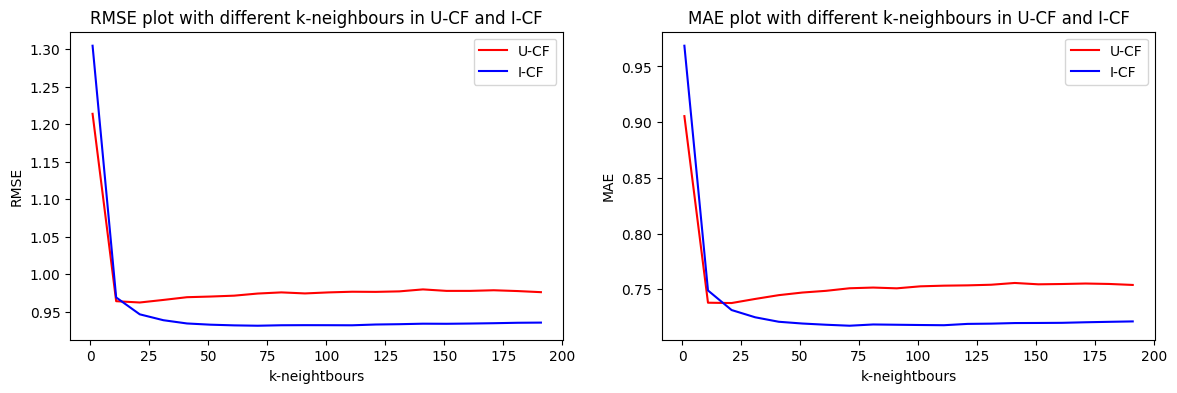

In [159]:
import matplotlib.pyplot as plt

xlabs = [i for i in range(1,201, 10)]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14,4))

ax1.set_title('RMSE plot with different k-neighbours in U-CF and I-CF')
ax1.plot(xlabs, rmse_ucf, '-r', label='U-CF')
ax1.plot(xlabs, rmse_icf, '-b', label='I-CF')
ax1.legend(loc='upper right')
ax1.set(xlabel='k-neightbours', ylabel='RMSE')

ax2.set_title('MAE plot with different k-neighbours in U-CF and I-CF')
ax2.plot(xlabs, mae_ucf, 'r', label='U-CF')
ax2.plot(xlabs, mae_icf, 'b', label='I-CF')
ax2.legend(loc='upper right')
ax2.set(xlabel='k-neightbours', ylabel='MAE')

plt.show()